In [1]:
from pathlib import Path
import duckdb
from textwrap import dedent
from datetime import datetime
from transformers import (
    AutoTokenizer, 
)
from sklearn.metrics import classification_report
from src.model_train.func import MultiLabels, TrainDistribution, preprocess_data
from src.model_train.pipeline_train import Pipeline

In [2]:
path = Path('/media/kevin/data_4t/cx_product_review/training_data')

file = path / 'eda_topic.parquet'
l1 = ['product_quality', 'pricing', 'delivery_service', 'packaging', 'seller_service', 'listing_accuracy', 'irrelevant']
labels = [f'topic_{i}' for i in l1]

query = f"""
select distinct 
item_id
, item_name
, comment_id
, comment
, {'\n, '.join(f'coalesce(topic_{i}, 0) topic_{i}' for i in l1)}
from read_parquet('{file}')
"""
df = duckdb.sql(query).pl()

print(df.shape, df['comment_id'].n_unique())
print(df.null_count().to_dict(as_series=False))
df.head()

(73966, 11) 73947
{'item_id': [0], 'item_name': [0], 'comment_id': [0], 'comment': [0], 'topic_product_quality': [0], 'topic_pricing': [0], 'topic_delivery_service': [0], 'topic_packaging': [0], 'topic_seller_service': [0], 'topic_listing_accuracy': [0], 'topic_irrelevant': [0]}


item_id,item_name,comment_id,comment,topic_product_quality,topic_pricing,topic_delivery_service,topic_packaging,topic_seller_service,topic_listing_accuracy,topic_irrelevant
i64,str,i64,str,i64,i64,i64,i64,i64,i64,i32
18270068868,"""Chai xịt khóa cố định lớp tran…",13770886849,"""Độ bền màu:ổn Công dụng:xịt kh…",1,1,0,0,0,0,0
14796477659,"""Giấy ăn YCOOL thùng 30 gói 300…",13835034152,"""Chất lượng sản phẩm:ok giấy k…",1,1,0,0,0,0,0
6307844444,"""[E-voucher] Mã Quà Tặng Shopee…",1841952223,"""Sản phẩm tuyệt vời. Giao hàng …",1,0,1,1,0,0,0
6307844444,"""[E-voucher] Mã Quà Tặng Shopee…",1859941724,"""Nén skd ks djs dnnsndmdm dnd. …",0,0,0,0,0,0,1
6307844444,"""[E-voucher] Mã Quà Tặng Shopee…",1863624832,"""- Mã quà tặng được sử dụng để …",0,1,0,0,0,0,0


In [3]:
TrainDistribution.label_stats(df, 'all', labels)

name,val,pct,data
str,i64,f64,str
"""topic_product_quality""",47428,0.641214,"""all"""
"""topic_pricing""",16243,0.219601,"""all"""
"""topic_delivery_service""",17602,0.237974,"""all"""
"""topic_packaging""",10127,0.136914,"""all"""
"""topic_seller_service""",12109,0.16371,"""all"""
"""topic_listing_accuracy""",22029,0.297826,"""all"""
"""topic_irrelevant""",3327,0.04498,"""all"""


Shape Train: (47337, 11), Valid: (11835, 11), Test: (14794, 11)


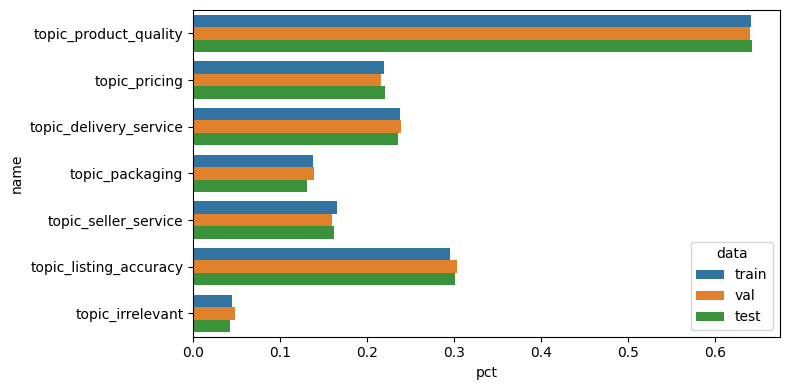

In [4]:
dist_check = TrainDistribution(df)
train, val, test = dist_check.split_train_valid_test(test_size=.2)
dist_check.check(labels)

In [5]:
col = ['comment_id', 'comment'] + labels
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

ds_train, ds_test, ds_val = dist_check.split_to_dataset(col, show_index=3)

Show example: 3
        Train: {'comment_id': 13591669642, 'comment': 'Thảm mỏng', 'topic_product_quality': 1, 'topic_pricing': 0, 'topic_delivery_service': 0, 'topic_packaging': 0, 'topic_seller_service': 0, 'topic_listing_accuracy': 0, 'topic_irrelevant': 0}
        Test: {'comment_id': 6384280595, 'comment': 'Ghi là 48 cái mà có 19 cái ?', 'topic_product_quality': 0, 'topic_pricing': 0, 'topic_delivery_service': 0, 'topic_packaging': 0, 'topic_seller_service': 0, 'topic_listing_accuracy': 1, 'topic_irrelevant': 0}
        Val: {'comment_id': 678448503, 'comment': 'Hàng giả kém chất lượng', 'topic_product_quality': 1, 'topic_pricing': 0, 'topic_delivery_service': 0, 'topic_packaging': 0, 'topic_seller_service': 0, 'topic_listing_accuracy': 0, 'topic_irrelevant': 0}



In [6]:
pretrain_name = 'bkai-foundation-models/vietnamese-bi-encoder'
tokenizer = AutoTokenizer.from_pretrained(pretrain_name)

In [7]:
train_encoded_dataset = ds_train.map(
    preprocess_data, 
    batched=True, 
    remove_columns=ds_train.column_names, 
    fn_kwargs={'labels': labels, 'tokenizer': tokenizer}
)
val_encoded_dataset = ds_val.map(
    preprocess_data, 
    batched=True, 
    remove_columns=ds_train.column_names, 
    fn_kwargs={'labels': labels, 'tokenizer': tokenizer}
)
test_encoded_dataset = ds_test.map(
    preprocess_data, 
    batched=True, 
    remove_columns=ds_train.column_names, 
    fn_kwargs={'labels': labels, 'tokenizer': tokenizer}
)

train_encoded_dataset.set_format('torch')
val_encoded_dataset.set_format('torch')
test_encoded_dataset.set_format('torch')

Map:   0%|          | 0/47337 [00:00<?, ? examples/s]

Map:   0%|          | 0/11835 [00:00<?, ? examples/s]

Map:   0%|          | 0/14794 [00:00<?, ? examples/s]

In [8]:
example = train_encoded_dataset[0]
print(example.keys())
print(tokenizer.decode(example['input_ids']))
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
<s> Thời gian giao hàng tạm được Đóng gói sản phẩm tạm được Chất lượng sản phẩm tạm được </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
['topic_product_quality', 'topic_delivery_service', 'topic_packaging']


In [9]:
pretrain_name = 'bkai-foundation-models/vietnamese-bi-encoder'
pipe = Pipeline(pretrain_name=pretrain_name, id2label=id2label, label2id=label2id)

time_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
folder = path / f'model_multi_labels_topic/{pretrain_name.split('/')[-1]}/{time_now}'
config = dict(    
    log_step=100,
    num_train_epochs=7,
    learning_rate=1e-4,
)
trainer = pipe.train(
    folder=folder, 
    train=train_encoded_dataset,
    val=val_encoded_dataset,
    **config
)

Pretrain: bkai-foundation-models/vietnamese-bi-encoder


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bkai-foundation-models/vietnamese-bi-encoder and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
100,0.417700,0.246223,0.813998,0.868622,0.561132
200,0.211700,0.194510,0.852052,0.899066,0.634052
300,0.163800,0.179175,0.866307,0.909280,0.668188
400,0.133500,0.173704,0.870656,0.913424,0.675116
500,0.109500,0.177421,0.869411,0.913087,0.675032
600,0.096100,0.177213,0.870640,0.913197,0.679003


***** train metrics *****
  epoch                    =        7.0
  total_flos               =  7929714GF
  train_loss               =     0.1811
  train_runtime            = 0:02:29.37
  train_samples_per_second =   2218.271
  train_steps_per_second   =      4.358


In [10]:
valid_result = trainer.predict(val_encoded_dataset)
print(valid_result.metrics)

valid_y_pred = MultiLabels().post_process(valid_result.predictions)
valid_report = classification_report(valid_result.label_ids, valid_y_pred, target_names=labels)
print(valid_report)

{'test_loss': 0.17370419204235077, 'test_f1': 0.8706561832653854, 'test_roc_auc': 0.9134237013099339, 'test_accuracy': 0.6751161808196029, 'test_runtime': 1.8377, 'test_samples_per_second': 6440.035, 'test_steps_per_second': 100.668}
                        precision    recall  f1-score   support

 topic_product_quality       0.90      0.93      0.91      7571
         topic_pricing       0.88      0.72      0.80      2561
topic_delivery_service       0.88      0.92      0.90      2825
       topic_packaging       0.84      0.90      0.87      1640
  topic_seller_service       0.80      0.81      0.81      1884
topic_listing_accuracy       0.85      0.85      0.85      3584
      topic_irrelevant       0.86      0.70      0.77       576

             micro avg       0.87      0.87      0.87     20641
             macro avg       0.86      0.83      0.84     20641
          weighted avg       0.87      0.87      0.87     20641
           samples avg       0.88      0.88      0.87     20

/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
test_result = trainer.predict(test_encoded_dataset)
print(test_result.metrics)

test_y_pred = MultiLabels().post_process(test_result.predictions)
test_report = classification_report(test_result.label_ids, test_y_pred, target_names=labels)
print(test_report)

{'test_loss': 0.17352846264839172, 'test_f1': 0.8706987256926854, 'test_roc_auc': 0.9137172965749104, 'test_accuracy': 0.6785183182371232, 'test_runtime': 2.5004, 'test_samples_per_second': 5916.563, 'test_steps_per_second': 92.784}
                        precision    recall  f1-score   support

 topic_product_quality       0.91      0.93      0.92      9507
         topic_pricing       0.87      0.73      0.79      3271
topic_delivery_service       0.88      0.93      0.90      3492
       topic_packaging       0.82      0.89      0.85      1942
  topic_seller_service       0.81      0.81      0.81      2404
topic_listing_accuracy       0.85      0.84      0.85      4448
      topic_irrelevant       0.83      0.73      0.77       628

             micro avg       0.87      0.87      0.87     25692
             macro avg       0.85      0.84      0.84     25692
          weighted avg       0.87      0.87      0.87     25692
           samples avg       0.88      0.88      0.87     256

/home/kevin/miniforge3/envs/llm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
path_md = str(path / f'model_multi_labels_topic/{pretrain_name.split('/')[-1]}/result_{time_now}.md')
with open(path_md, 'w', encoding="utf-8") as md:
    text = dedent(f"""
    Config:
    {config}
    
    Valid Classification Report:
    {valid_report}
    
    Test Classification Report:
    {test_report}
    """)
    md.write(text)